In [3]:
# ! pip install imbalanced-learn
# ! pip install lime
# ! pip install textblob
# ! pip install contractions
# ! pip install spacy
# ! python -m spacy download en_core_web_sm
# ! pip install gensim
# ! pip install python-Levenshtein

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import pickle 
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# import lime
# import lime.lime_tabular
# from gensim import matutils, models
# import scipy.sparse

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation

from helpers import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load cleaned data
combine title and body of text 

In [2]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita = aita_2.dropna(subset=['body_clean', 'title_clean']).loc[:,['body_polarity','body_subjectivity','is_asshole']]
aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']
aita.dropna(inplace=True)
aita.reset_index(drop=True)

,body_polarity,body_subjectivity,is_asshole,title_body_combo
0,-0.156818,0.656818,1,I write an explanation in til and come off a...
1,0.034848,0.449242,1,throw my parent donut awaymy parent be diabe...
2,0.000000,0.000000,0,I tell a goth girl she look like a clownI be four
3,0.000000,0.000000,1,argument I have with another redditor in rhi...
4,0.040104,0.369792,1,have a disagreement about le miserable with ...
...,...,...,...,...
97450,0.016111,0.385278,0,for tell my sister she be be a spoiled bratm...
97451,0.068461,0.474614,0,for tell my husband to f off after he relent...
97452,-0.076333,0.493467,0,for attempt to keep my student out of adult ...
97453,0.067130,0.426132,0,if I leave my brother fate up to the statea ...


## 1 - train test split

In [3]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=11)
print(X_train.shape, X_test.shape)

(96480, 3) (975, 3)


## 2 - Instantiate CountVectorizer 

In [4]:
# add_stop_words = ['like', 'get', 'go', 'say', 'tell', 'thats', 'want', 'time',
#                   'youre', 'got', 'gonna', 'time', 'also', 'yeah', 'said']
# stop = set(stopwords.words('english')).union(add_stop_words)
# vec = CountVectorizer(stop_words=stop, min_df=0.005, max_df=0.8, ngram_range=(1, 2))
# cv = vec.fit(X_train['title_body_combo'])
# len(cv.get_feature_names())

#### (Save / load fitted CountVectorizer)

In [5]:
# pickle.dump(cv, open('models/cv_fit_train_2.sav', 'wb'))
cv = pickle.load(open('models/cv_fit_train_2.sav', 'rb'))
len(cv.get_feature_names())

3183

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [6]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols, index=X_train.index)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols, index=X_test.index)

In [7]:
# train_word_count = dtm_train.sum(axis=0)
# train_word_count.sort_values(ascending=False)[:10]

In [8]:
# ((96480, 3183), (975, 3183))
dtm_train.shape, dtm_test.shape

((96480, 3183), (975, 3183))

## 3 - PCA

In [9]:
# pca = IncrementalPCA(n_components=1000, batch_size=1050)
# pca.fit(dtm_train)
# print(pca.explained_variance_ratio_.sum())

#### Save / Load fitted PCA

In [10]:
# pickle.dump(pca, open('models/pca_2.sav', 'wb'))
pca = pickle.load(open('models/pca_2.sav', 'rb'))
print(pca.get_params)
print(pca.explained_variance_ratio_.sum())
# 0.883252998748863

<bound method BaseEstimator.get_params of IncrementalPCA(batch_size=1050, n_components=1000)>
0.8832529987488633


### 3.a Scree plot, check number of components is appropriate

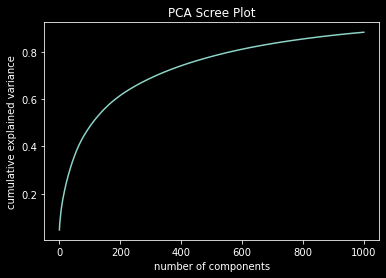

In [11]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Scree Plot')
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

### 3.b - Transform train/test Document-Term-matrix with PCA

In [12]:
dtm_train_pca = pca.transform(dtm_train)
dtm_test_pca = pca.transform(dtm_test)

Build DataFrame of PCA Components

In [13]:
col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names, index=dtm_train.index)
dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names, index=dtm_test.index)

Combine PCA components and sentiment analysis scores into one DataFrame

In [14]:
X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train_pca_df], axis=1)
X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']],dtm_test_pca_df], axis=1)

In [18]:
X_train_post_dtm_pca.head()

,body_polarity,body_subjectivity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_991,PC_992,PC_993,PC_994,PC_995,PC_996,PC_997,PC_998,PC_999,PC_1000
10404,0.089698,0.382755,6.253791,2.959302,0.712668,-2.008379,-1.226649,-1.164330,-0.139047,3.269885,...,-0.374262,-0.325715,-0.470150,0.470259,0.161501,0.001576,0.727497,0.521130,0.419684,0.312693
46696,-0.140000,0.601585,6.277193,-0.242311,-2.822363,-1.489495,-3.805064,4.139399,-2.640378,1.128195,...,0.066434,-0.263564,0.167467,0.049622,-0.292251,0.222198,0.137764,-0.189065,0.057128,0.335629
94429,0.034758,0.575265,0.259986,-0.535410,-4.440283,0.100041,1.118445,-0.717248,1.045213,-1.709068,...,-0.058862,0.071192,0.064069,-0.027584,0.029386,0.028333,0.034270,0.002774,-0.008224,-0.081641
32916,-0.009470,0.545676,0.093155,-0.822719,1.947825,-0.550729,-1.438958,1.527924,1.225077,0.426274,...,-0.229633,0.450516,-0.050805,-0.218510,-0.067159,-0.023230,0.508755,0.089572,-0.112279,-0.063050
90078,0.196644,0.494792,2.059154,-1.483851,-0.874267,-0.683708,-2.273810,0.873202,-1.845881,0.982150,...,-0.188098,0.129731,-0.019399,-0.244933,0.135543,-0.022551,0.096471,-0.102188,0.005239,0.383625


In [16]:
print(X_train_post_dtm_pca.shape, y_train.shape)
print(X_test_post_dtm_pca.shape, y_test.shape)

(96480, 1002) (96480,)
(975, 1002) (975,)


#### 3.c Oversample minority class with SMOTE

In [17]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_post_dtm_pca, y_train)
X_test_smote, y_test_smote = SMOTE().fit_resample(X_test_post_dtm_pca, y_test)
Counter(y_train_smote), Counter(y_test_smote)

(Counter({0: 70299, 1: 70299}), Counter({1: 710, 0: 710}))

# Models

## 1 - Random Forest Models

In [13]:
start = time.time()
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train_smote, y_train_smote)
end = time.time()
print((end-start)/60)

2.3585612058639525


In [14]:
y_pred_train = rfc.predict(X_train_smote)
print(confusion_matrix(y_train_smote,y_pred_train))
# print(classification_report(y_train,y_pred_train))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train)}')

[[70299     0]
 [    0 70299]]
F1 Score = 1.0
Accuracy Score = 1.0


In [15]:
y_pred_test = rfc.predict(X_test_smote)
print(confusion_matrix(y_test_smote,y_pred_test))
# print(classification_report(y_test,y_pred_test))
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test)}')

[[614  96]
 [388 322]]
F1 Score = 0.5709219858156029
Accuracy Score = 0.6591549295774648


## 2 - Logistic Regression

In [78]:
start = time.time()

lr = LogisticRegression(max_iter=1500)
lr.fit(X_train_smote, y_train_smote)

end = time.time()
print((end-start)/60)

0.1429072618484497


In [84]:
# pickle.dump(lr, open('models/lr.sav', 'wb'))

In [79]:
y_pred_train_lr = lr.predict(X_train_smote)
conf = confusion_matrix(y_train_smote,y_pred_train_lr) 
np.round(conf/sum(conf), decimals=2)
# print(classification_report(y_train,y_pred_train_lr))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_lr)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_lr)}')

F1 Score = 0.6696413526283508
Accuracy Score = 0.6513961791775132


In [80]:
y_pred_test_lr = lr.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_lr))
# print(classification_report(y_test,y_pred_test_lr))
print(f'F1 Score = {f1_score(y_test,y_pred_test_lr)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_lr)}')

[[405 305]
 [119 146]]
F1 Score = 0.40782122905027934
Accuracy Score = 0.5651282051282052


### 2.b Logistic Regression pipeline

In [31]:
# text_clf = Pipeline([
#                      ('clf', LogisticRegression(max_iter=1000, penalty='l2'))
#                     ])
# params = {
#           'clf__solver': ['saga','lbfgs','newton-cg']
#          }
# gs_clf = GridSearchCV(text_clf, params, n_jobs=-1, scoring='f1')

In [64]:
# print(gs_clf.best_score_)
# print(gs_clf.best_params_)

In [26]:
start = time.time()
lr_smote = LogisticRegression(max_iter=500, penalty='l2', solver='lbfgs')
lr_smote.fit(X_train_smote, y_train_smote)
end = time.time()
print(f'run time = {(end-start)/60} mins')

run time = 0.14300824801127116 mins


In [27]:
# pickle.dump(lr_1, open('models/lr_1.sav', 'wb'))

In [29]:
print('train smote')
y_pred_train = lr_smote.predict(X_train_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train)}')
print('\ntest smote')
y_pred_test = lr_smote.predict(X_test_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test)}')
print('\ntrain no smote')
y_pred_train = lr_smote.predict(X_train_post_dtm_pca)
print(f'F1 Score = {f1_score(y_train,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train)}')
print('\ntest no smote')
y_pred_test = lr_smote.predict(X_test_post_dtm_pca)
print(f'F1 Score = {f1_score(y_test,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test)}')

train smote
F1 Score = 0.6696197411003236
Accuracy Score = 0.6514744164212862

test smote
F1 Score = 0.6510695187165775
Accuracy Score = 0.6323943661971831

train no smote
F1 Score = 0.4385279340404517
Accuracy Score = 0.5934390547263682

test no smote
F1 Score = 0.39772727272727276
Accuracy Score = 0.5651282051282052


(max_iter=1000, penalty='l2', solver='lbfgs') <br>
train<br>
F1 Score = 0.6686894840467136 <br>
Accuracy Score = 0.6505213445425966<br>
test<br>
F1 Score = 0.6613861386138614<br>
Accuracy Score = 0.6387323943661972

In [21]:
start = time.time()
lr_no_smote = LogisticRegression(max_iter=1500, penalty='l2', solver='lbfgs')
lr_no_smote.fit(X_train_post_dtm_pca, y_train)
end = time.time()
print(f'run time = {(end-start)/60} mins')

run time = 0.09725179274876912 mins


In [22]:
print('train smote')
y_pred_train = lr_no_smote.predict(X_train_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train)}')
print('\ntest smote')
y_pred_test = lr_no_smote.predict(X_test_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test)}')
print('\ntrain no smote')
y_pred_train = lr_no_smote.predict(X_train_post_dtm_pca)
print(f'F1 Score = {f1_score(y_train,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train)}')
print('\ntest no smote')
y_pred_test = lr_no_smote.predict(X_test_post_dtm_pca)
print(f'F1 Score = {f1_score(y_test,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test)}')

train smote
[[68950  1349]
 [67856  2443]]
F1 Score = 0.06594593135468546
Accuracy Score = 0.5077810495170628

test smote
[[698  12]
 [698  12]]
F1 Score = 0.0326975476839237
Accuracy Score = 0.5

train no smote
[[68950  1349]
 [24684  1497]]
F1 Score = 0.10314534743514658
Accuracy Score = 0.7301720563847429

test no smote
[[698  12]
 [256   9]]
F1 Score = 0.06293706293706294
Accuracy Score = 0.7251282051282051


### Testing predictions

In [57]:
# aita = pd.read_csv('data/aita_clean.csv')
top_100 = aita[['title','body','verdict','is_asshole','score']].sort_values('score', ascending=False).head(3)

In [58]:
top_100['body']

81235    I am a high schooler with a weekend job at a c...
69302    Note. My step-daughter, Madeline, was about a ...
49802    We had a family dinner this evening. My family...
Name: body, dtype: object

In [59]:
diag_100 = Proctologist(model=lr_1).diagnosis(top_100['body'].values)

In [60]:
pd.concat([diag_100, top_100[['body', 'verdict', 'is_asshole']].reset_index(drop=True)], axis=1)

,prob not asshole,prob asshole,verdict,label,body,verdict,is_asshole
0,0.69,0.31,0.0,Not Asshole,I am a high schooler with a weekend job at a c...,not the asshole,0
1,0.40,0.60,1.0,Asshole,"Note. My step-daughter, Madeline, was about a ...",everyone sucks,1
2,0.72,0.28,0.0,Not Asshole,We had a family dinner this evening. My family...,everyone sucks,1


### 2.c Logistic Regression with best estimators

In [26]:
start = time.time()

lr = LogisticRegression(n_jobs=-1, max_iter=1000, penalty='l2')
lr.fit(X_train_smote, y_train_smote)

end = time.time()
print((end-start)/60)

0.13632711966832478


In [27]:
y_pred_train_lr = lr.predict(X_train_smote)
conf = confusion_matrix(y_train_smote,y_pred_train_lr) 
np.round(conf/sum(conf), decimals=2)
# print(classification_report(y_train,y_pred_train_lr))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_lr)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_lr)}')

F1 Score = 0.6697968944727004
Accuracy Score = 0.6513677292706866


In [29]:
y_pred_test = lr.predict(X_test_smote)
print(confusion_matrix(y_test_smote,y_pred_test))
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test)}')

[[411 299]
 [227 483]]
F1 Score = 0.6474530831099196
Accuracy Score = 0.6295774647887324


## 3. Naive Bayes

In [66]:
X_train_dtm_smote, y_train_smote = SMOTE().fit_resample(dtm_train, y_train)
X_test_dtm_smote, y_test_smote = SMOTE().fit_resample(dtm_test, y_test)

Counter({0: 70299, 1: 70299})

In [68]:
nb = MultinomialNB()
nb.fit(X_train_dtm_smote, y_train_smote)

MultinomialNB()

In [69]:
y_pred_train_nb = nb.predict(X_train_dtm_smote)
print(confusion_matrix(y_train_smote,y_pred_train_nb))
# print(classification_report(y_train,y_pred_train_nb))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_nb)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_nb)}')

[[51295 19004]
 [18088 52211]]
F1 Score = 0.7378916573625224
Accuracy Score = 0.7361840139973541


In [70]:
y_pred_test_nb = nb.predict(dtm_test)
print(confusion_matrix(y_test,y_pred_test_nb))
# print(classification_report(y_test,y_pred_test_nb))
print(f'F1 Score = {f1_score(y_test,y_pred_test_nb)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_nb)}')

[[511 199]
 [158 107]]
F1 Score = 0.37478108581436076
Accuracy Score = 0.6338461538461538


## 4 - Support Vector Machines (SVM)

In [37]:
svm_pipe = Pipeline([('clf-svm', SGDClassifier(n_jobs=-1))])
pip_params = {'clf-svm__alpha': (1e-2, 1e-4),
             'clf-svm__loss': ('log', 'perceptron', 'hinge')}
gs_svm = GridSearchCV(svm_pipe, pip_params, n_jobs=-1)

In [38]:
gs_svm = gs_svm.fit(X_train_smote, y_train_smote)

In [39]:
print(gs_svm.best_score_)
print(gs_svm.best_params_)

0.637513170377248
{'clf-svm__alpha': 0.01, 'clf-svm__loss': 'log'}


In [43]:
y_pred_train_svm = gs_svm.predict(X_train_smote)
print(confusion_matrix(y_train_smote,y_pred_train_svm))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_svm)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_svm)}')

[[40615 29684]
 [20198 50101]]
F1 Score = 0.6676394552383997
Accuracy Score = 0.645215436919444


In [40]:
y_pred_test_svm = gs_svm.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_svm))
print(f'F1 Score = {f1_score(y_test,y_pred_test_svm)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_svm)}')

[[391 319]
 [114 151]]
F1 Score = 0.41088435374149657
Accuracy Score = 0.5558974358974359


## Trying Predictions

In [54]:
texts = ['I pushed my mom off a cliff, and my whole family is mad at me, but I don\'t feel bad about it, aita?',
        'My boyfriend cheated on me, so I kicked him out of the house I own, he threatened to call the police, and I told him to leave me alone.', 
        'I cheated on my boyfriend and he kicked me out of his house, I broke in in the middle of night, I did not pay rent.',
        'I talked to my ex on a regular basis, and my girlfriend isn\'t happy about it, she said she\'s going to leave me', 
        'my biological parents spent years looking for me, but I am happy with my adoptive parents and consider them my real family, I don\'t want to have any contact with my biological parents after they abandoned me']

In [55]:
Proctologist().diagnosis(texts)

,prob not asshole,prob asshole,verdict,label
0,0.38,0.62,1.0,Asshole
1,0.51,0.49,0.0,Not Asshole
2,0.22,0.78,1.0,Asshole
3,0.29,0.71,1.0,Asshole
4,0.35,0.65,1.0,Asshole
